In [1]:
from torch import nn
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
from torch.nn import functional as F
import torch
from torch import nn

Tensor = TypeVar('torch.tensor')

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass




class VanillaVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512, 1024]  # Added 1024 for an additional layer

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        
        # Adjust the linear layers for mu and var
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

        # Build Decoder
        modules = []
        
        # Adjust decoder input for the added layer
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=3,
                                      kernel_size=3, padding=1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 1024, 2, 2)  # Adjust for the added layer
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        return self.forward(x)[0]


/tmp/ipykernel_586483/2413254220.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/vae_celeba_128.pth'))


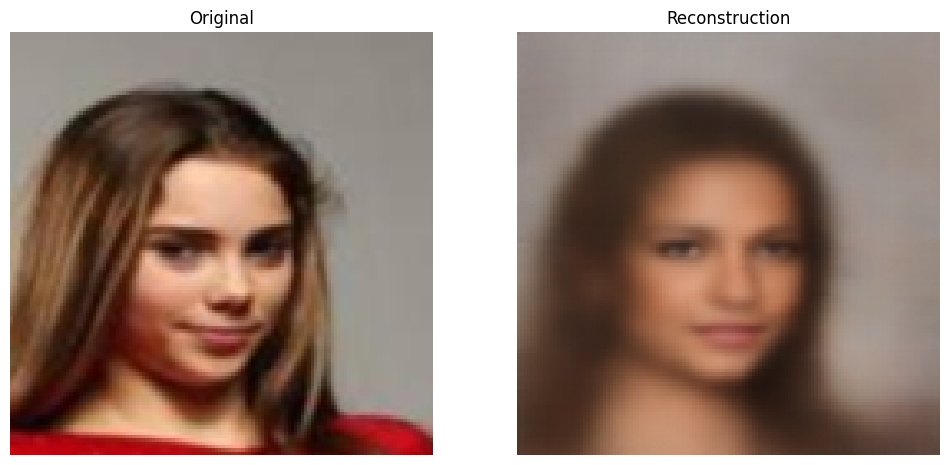

In [3]:
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt

device = "cuda"
image_folder_path = '../data/celeba/img_align_celeba/'

# Hyperparameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 100
latent_dim = 128
img_size = 128
kld_weight = 0.00025  # weight of KL divergence in the loss

model = VanillaVAE(in_channels=3, latent_dim=128)
model.load_state_dict(torch.load('weights/vae_celeba_128.pth'))
model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Use ImageFolder to load images from a directory
image_dataset = datasets.ImageFolder(root=image_folder_path, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Step 2: Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch = next(iter(train_loader))
images, _ = batch

images = images.to(device)
reconstructions = model(images)
reconstructions = reconstructions[0]

idx = 1

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(images[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructions[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.title("Reconstruction")
plt.axis('off')
plt.show()

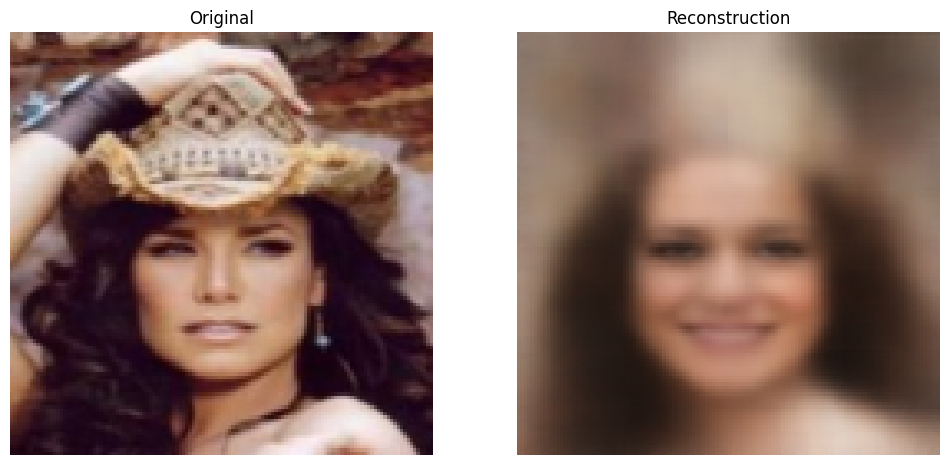

In [14]:
idx = 14

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(images[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.imsave('ref_3.png', images[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructions[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.imsave('recon_3.png', reconstructions[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.title("Reconstruction")
plt.axis('off')
plt.show()

## Random samples

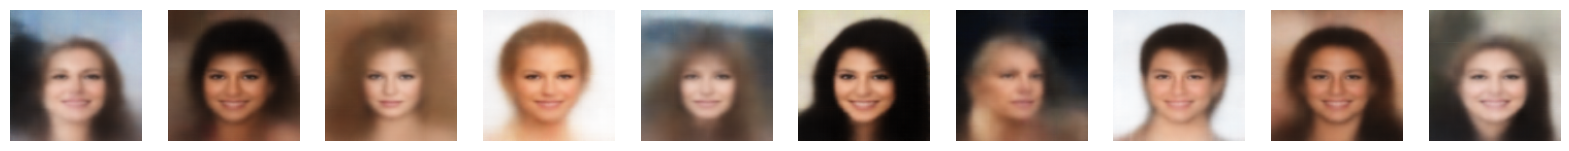

In [9]:
import os

num_samples = 10
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

samples = model.sample(num_samples, current_device)

os.makedirs('./images/samples', exist_ok=True)
# Display the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(samples[i].permute(1, 2, 0).cpu().detach().numpy())
    ax.axis('off')
    plt.imsave(f'./images/samples/sample_{i}.png', samples[i].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

## Interpolation

In [21]:
import torch
import matplotlib.pyplot as plt
import os 
from PIL import Image

output_dir = './interpolations/'
os.makedirs(output_dir, exist_ok=True)


# Assuming you have your train_dataset and model loaded
idx = 9

# Select two images from the dataset
image1, _ = train_dataset[idx]
image2, _ = train_dataset[idx+1]

# Convert the images to tensors and move them to the device
image1 = image1.unsqueeze(0).to(device)
image2 = image2.unsqueeze(0).to(device)

# Pass the images through the model to obtain their latent codes
latent_code1 = model.encode(image1)[0]
latent_code2 = model.encode(image2)[0]

# Define the number of interpolation steps
num_steps = 128

# Generate interpolation factors between 0 and 1
alphas = torch.linspace(0, 1, steps=num_steps).to(device)

# Perform linear interpolation between the latent codes
interpolated_codes = torch.stack([torch.lerp(latent_code1, latent_code2, alpha) for alpha in alphas])

# Generate the reconstructed images from the interpolated latent codes
reconstructed_images = model.decode(interpolated_codes)

# Convert the tensors to numpy arrays for display
image1 = image1.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
image2 = image2.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
reconstructed_images = reconstructed_images.squeeze(1).permute(0, 2, 3, 1).cpu().detach().numpy()

# Save the interpolated images
for i in range(num_steps):
    img = (reconstructed_images[i] * 255).astype(np.uint8)  # Convert to 8-bit image
    img = Image.fromarray(img)
    img.save(os.path.join(output_dir, f'interpolated_{i+1}.png'))



## Latent space

### Encode the images

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Number of images to embed
num_images = 10000

# Storage for latent codes
latent_codes = []

# Ensure the model is in evaluation mode
model.eval()

# Loop through the first 1000 images in the training set
with torch.no_grad():
    for i in range(num_images):
        image, _ = train_dataset[i]
        image = image.unsqueeze(0).to(device)
        
        # Obtain the latent code and flatten it
        latent_code = model.encode(image)[0].cpu().numpy().flatten()
        latent_codes.append(latent_code)

# Convert to a numpy array
latent_codes = np.array(latent_codes)

### PCA

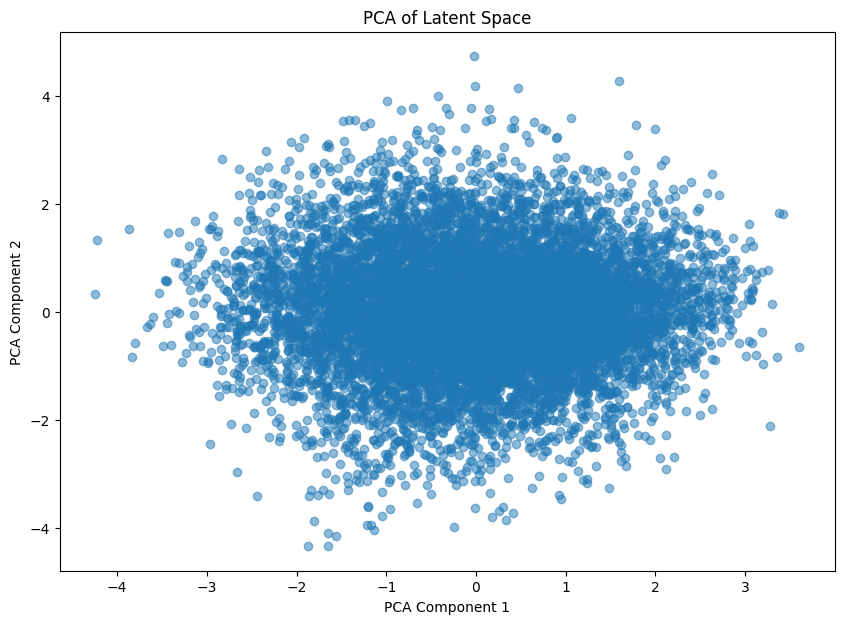

In [18]:


# Perform PCA
pca = PCA(n_components=2)  # You can change to n_components=3 for 3D plotting
pca_result = pca.fit_transform(latent_codes)

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of Latent Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


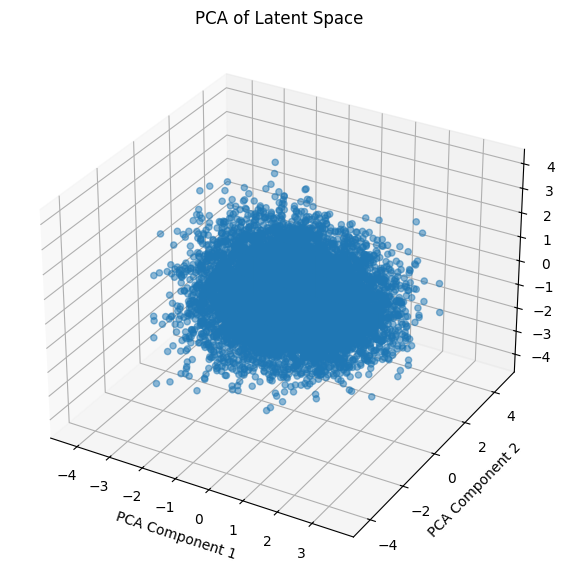

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_codes)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.5)
ax.set_title('PCA of Latent Space')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()
